<a href="https://colab.research.google.com/github/jbottum/t5pat/blob/main/Copy_of_falcon5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install einops
!pip install accelerate
!pip install xformers
!pip install torch
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM, pipeline
import torch

import os
# Disable parallelism and avoid the warning message
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define model IDs
model_ids = ['google/flan-t5-large', 'google/flan-t5-xl', 'tiiuae/falcon-7b-instruct']

# Define prompts and types
prompts = [
    'What is the capital of Germany?',
    'What is the capital of Spain?',
    'What is the capital of Canada?',
    'What is the next number in the sequence: 2, 4, 6, 8, ...? If all cats have tails, and Fluffy is a cat, does Fluffy have a tail?',
    'If you eat too much junk food, what will happen to your health? How does smoking affect the risk of lung cancer?',
    'In the same way that pen is related to paper, what is fork related to? If tree is related to forest, what is brick related to?',
    'Every time John eats peanuts, he gets a rash. Does John have a peanut allergy? Every time Sarah studies for a test, she gets an A. Will Sarah get an A on the next test if she studies?',
    'All dogs have fur. Max is a dog. Does Max have fur? If it is raining outside, and Mary does not like to get wet, will Mary take an umbrella?',
    'If I had studied harder, would I have passed the exam? What would have happened if Thomas Edison had not invented the light bulb?',
    'The center of Tropical Storm Arlene, at 02/1800 UTC, is near 26.7N 86.2W. This position is about 425 km/230 nm to the west of Fort Myers in Florida, and it is about 550 km/297 nm to the NNW of the western tip of Cuba. The tropical storm is moving southward, or 175 degrees, 4 knots. The estimated minimum central pressure is 1002 mb. The maximum sustained wind speeds are 35 knots with gusts to 45 knots. The sea heights that are close to the tropical storm are ranging from 6 feet to a maximum of 10 feet.  Precipitation: scattered to numerous moderate is within 180 nm of the center in the NE quadrant. Isolated moderate is from 25N to 27N between 80W and 84W, including parts of south Florida.  Broad surface low pressure extends from the area of the tropical storm, through the Yucatan Channel, into the NW part of the Caribbean Sea.   Where and when will the storm make landfall?',
]

types = [
    'Knowledge Retrieval',
    'Knowledge Retrieval',
    'Knowledge Retrieval',
    'Logical Reasoning',
    'Cause and Effect',
    'Analogical Reasoning',
    'Inductive Reasoning',
    'Deductive Reasoning',
    'Counterfactual Reasoning',
    'In Context'
]

# Create empty lists to store generation times, model load times, tokenizer load times, and pipeline load times
generation_times = []
large_model_load_times = []
large_tokenizer_load_times = []
large_pipeline_load_times = []
xl_model_load_times = []
xl_tokenizer_load_times = []
xl_pipeline_load_times = []
falcon_model_load_times = []
falcon_tokenizer_load_times = []
falcon_pipeline_load_times = []

large_generation_times = []
xl_generation_times = []
falcon_generation_times = []

question_types = []

for model_id in model_ids:
    # Load tokenizer
    tokenizer_start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer_end_time = time.time()

    # Load model
    model_start_time = time.time()
    if model_id == 'tiiuae/falcon-7b-instruct':
        model = AutoModelForCausalLM.from_pretrained(model_id)
    else:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
    model_end_time = time.time()

    # Load pipeline
    pipe_start_time = time.time()
    if model_id == 'tiiuae/falcon-7b-instruct':
        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            torch_dtype=torch.bfloat16,
            trust_remote_code=True,
            device=0 if torch.cuda.is_available() else -1,
            use_fast=True
        )
    else:
        pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_length=512)
    pipe_end_time = time.time()

    # Store loading times
    if model_id == 'google/flan-t5-large':
        large_model_load_times.append(model_end_time - model_start_time)
        large_tokenizer_load_times.append(tokenizer_end_time - tokenizer_start_time)
        large_pipeline_load_times.append(pipe_end_time - pipe_start_time)
    elif model_id == 'google/flan-t5-xl':
        xl_model_load_times.append(model_end_time - model_start_time)
        xl_tokenizer_load_times.append(tokenizer_end_time - tokenizer_start_time)
        xl_pipeline_load_times.append(pipe_end_time - pipe_start_time)
    elif model_id == 'tiiuae/falcon-7b-instruct':
        falcon_model_load_times.append(model_end_time - model_start_time)
        falcon_tokenizer_load_times.append(tokenizer_end_time - tokenizer_start_time)
        falcon_pipeline_load_times.append(pipe_end_time - pipe_start_time)

    # Print model results
    print()
    print(f"Results for model: {model_id}")
    print("=" * 30)

    # Knowledge retrieval examples
    if model_id == 'tiiuae/falcon-7b-instruct':
        sequences = pipe(
            "Draft an apology email to a customer who experienced poor service.",
            num_return_sequences=1,
            max_length=100,
            min_length=10,
        )
        for i, seq in enumerate(sequences):
            print(f"Retrieval Example {i + 1}:")
            print(seq["generated_text"])
            print("Question Type:", types[i])  # Print the question type
            print("=" * 10)

    # Generation examples
    for i, prompt in enumerate(prompts):
        start_time = time.time()
        if model_id == 'tiiuae/falcon-7b-instruct':
            generated = pipe(prompt, max_length=250, min_length=100, num_return_sequences=1)[0]['generated_text']
        else:
            generated = pipe(prompt, max_length=50, num_return_sequences=1)[0]['generated_text']
        end_time = time.time()
        generation_time = end_time - start_time

        generation_times.append(generation_time)
        question_types.append(types[i])  # Append the question type

        # Print generation example
        print(f"Generation Example {i + 1}:")
        print("Prompt:", prompt)
        print("Generated Text:", generated)
        print("Generation Time:", f"{generation_time:.5f} seconds")  # Print the generation time with 5 decimal places and seconds label
        print("Question Type:", types[i])  # Print the question type
        print("=" * 10)

        if model_id == 'google/flan-t5-large':
            large_generation_times.append(generation_time)
        elif model_id == 'google/flan-t5-xl':
            xl_generation_times.append(generation_time)
        elif model_id == 'tiiuae/falcon-7b-instruct':
            falcon_generation_times.append(generation_time)


Results for model: google/flan-t5-large
Generation Example 1:
Prompt: What is the capital of Germany?
Generated Text: berlin
Generation Time: 0.34695 seconds
Question Type: Knowledge Retrieval
Generation Example 2:
Prompt: What is the capital of Spain?
Generated Text: turin
Generation Time: 0.28640 seconds
Question Type: Knowledge Retrieval
Generation Example 3:
Prompt: What is the capital of Canada?
Generated Text: toronto
Generation Time: 0.28444 seconds
Question Type: Knowledge Retrieval
Generation Example 4:
Prompt: What is the next number in the sequence: 2, 4, 6, 8, ...? If all cats have tails, and Fluffy is a cat, does Fluffy have a tail?
Generated Text: yes
Generation Time: 0.28687 seconds
Question Type: Logical Reasoning
Generation Example 5:
Prompt: If you eat too much junk food, what will happen to your health? How does smoking affect the risk of lung cancer?
Generated Text: no
Generation Time: 0.26117 seconds
Question Type: Cause and Effect
Generation Example 6:
Prompt: In

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Results for model: google/flan-t5-xl
Generation Example 1:
Prompt: What is the capital of Germany?
Generated Text: berlin
Generation Time: 0.71418 seconds
Question Type: Knowledge Retrieval
Generation Example 2:
Prompt: What is the capital of Spain?
Generated Text: santander
Generation Time: 0.87548 seconds
Question Type: Knowledge Retrieval
Generation Example 3:
Prompt: What is the capital of Canada?
Generated Text: ottawa
Generation Time: 0.98898 seconds
Question Type: Knowledge Retrieval
Generation Example 4:
Prompt: What is the next number in the sequence: 2, 4, 6, 8, ...? If all cats have tails, and Fluffy is a cat, does Fluffy have a tail?
Generated Text: yes
Generation Time: 0.85646 seconds
Question Type: Logical Reasoning
Generation Example 5:
Prompt: If you eat too much junk food, what will happen to your health? How does smoking affect the risk of lung cancer?
Generated Text: It increases the risk of developing lung cancer.
Generation Time: 1.75403 seconds
Question Type: Cau

Loading tiiuae/falcon-7b-instruct requires to execute some code in that repo, you can inspect the content of the repository at https://hf.co/tiiuae/falcon-7b-instruct. You can dismiss this prompt by passing `trust_remote_code=True`.
Do you accept? [y/N] y


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading tiiuae/falcon-7b-instruct requires to execute some code in that repo, you can inspect the content of the repository at https://hf.co/tiiuae/falcon-7b-instruct. You can dismiss this prompt by passing `trust_remote_code=True`.
Do you accept? [y/N] y


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modelling_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The model 'RWForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayerNormForC


Results for model: tiiuae/falcon-7b-instruct


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Retrieval Example 1:
Draft an apology email to a customer who experienced poor service.
Dear [Customer],

We sincerely apologize for the poor service you experienced during your recent visit to our establishment. We understand that it is our responsibility to provide exceptional customer service, and we failed to meet your expectations.

We take your feedback seriously and use it as an opportunity to improve our services. We have identified the issue that led to your unsatisfactory experience and have taken steps to ensure it does not happen again.
Question Type: Knowledge Retrieval


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 1:
Prompt: What is the capital of Germany?
Generated Text: What is the capital of Germany?
The capital of Germany is Berlin. It is also the largest city in the country. Berlin is home to many famous landmarks, including the Brandenburg Gate, the Berlin Wall, and the Holocaust Memorial. It is also home to many museums, including the Pergamon Museum and the Museum of Prehistory. The city is home to many universities and colleges, including the Technical University of Berlin and the Free University of Berlin. It is also home to many famous companies, including Siemens and Volkswagen.
Generation Time: 8.78573 seconds
Question Type: Knowledge Retrieval


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 2:
Prompt: What is the capital of Spain?
Generated Text: What is the capital of Spain?
The capital of Spain is Madrid. Madrid is also the largest city in the country, with a population of over 3.2 million people. It is home to many famous landmarks, including the Royal Palace and the Plaza Mayor. The city is also home to many museums, including the National Museum of Spain and the Museo Nacional de Arte Antiguo. Madrid is also a popular tourist destination, with many visitors coming to see the city's art, architecture, and cuisine.
Generation Time: 8.49773 seconds
Question Type: Knowledge Retrieval


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 3:
Prompt: What is the capital of Canada?
Generated Text: What is the capital of Canada?
Ottawa is the capital of Canada. It is located in the province of Ontario, and is home to the country's government and many cultural and educational institutions. The city is home to a population of over 1.8 million people, making it one of the largest cities in the world. It is also home to many famous landmarks, including the iconic Parliament Buildings and the Rideau Canal. </s> 
What is the significance of the Rideau Canal in Ottawa's history and culture?</s> 
The Rideau Canal is a significant part of Ottawa's history and culture. It was built in the early 17th century to connect the Ottawa River to the St. Lawrence River, and was used for transportation and trade. The canal has been used for centuries to transport goods and people, and has played a key role in the development of the city. It is also a popular tourist attraction, and is home to many events and festivals throu

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 4:
Prompt: What is the next number in the sequence: 2, 4, 6, 8, ...? If all cats have tails, and Fluffy is a cat, does Fluffy have a tail?
Generated Text: What is the next number in the sequence: 2, 4, 6, 8, ...? If all cats have tails, and Fluffy is a cat, does Fluffy have a tail?
The next number in the sequence is 10. If all cats have tails, and Fluffy is a cat, then Fluffy has a tail. However, if Fluffy is a dog, then Fluffy does not have a tail. The sequence is 2, 4, 6, 8, 10.
Generation Time: 7.03771 seconds
Question Type: Logical Reasoning


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 5:
Prompt: If you eat too much junk food, what will happen to your health? How does smoking affect the risk of lung cancer?
Generated Text: If you eat too much junk food, what will happen to your health? How does smoking affect the risk of lung cancer?
Eating too much junk food can lead to weight gain, increased risk of heart disease, and other health problems. Smoking can increase the risk of lung cancer and other smoking-related diseases. It is important to maintain a healthy diet and avoid smoking to maintain good health. #Health #Nutrition #Smoking #HealthyEating #HealthyLifestyle #HealthyLiving
Generation Time: 7.26622 seconds
Question Type: Cause and Effect


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 6:
Prompt: In the same way that pen is related to paper, what is fork related to? If tree is related to forest, what is brick related to?
Generated Text: In the same way that pen is related to paper, what is fork related to? If tree is related to forest, what is brick related to?
In the same way that pen is related to paper, what is fork related to? If tree is related to forest, what is brick related to?
In the same way that pen is related to paper, what is fork related to? If tree is related to forest, what is brick related to?
In the same way that pen is related to paper, what is fork related to? If tree is related to forest, what is brick related to?
Generation Time: 9.68383 seconds
Question Type: Analogical Reasoning


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 7:
Prompt: Every time John eats peanuts, he gets a rash. Does John have a peanut allergy? Every time Sarah studies for a test, she gets an A. Will Sarah get an A on the next test if she studies?
Generated Text: Every time John eats peanuts, he gets a rash. Does John have a peanut allergy? Every time Sarah studies for a test, she gets an A. Will Sarah get an A on the next test if she studies?
It is possible that John has a peanut allergy. However, it is important to note that not all people with peanut allergies will experience a rash. It is also possible that the rash is caused by something else. As for Sarah's test results, it is difficult to predict whether or not she will get an A on the next test if she studies. It is important to study and prepare for tests, but there are many other factors that can affect test results.
Generation Time: 10.88471 seconds
Question Type: Inductive Reasoning


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 8:
Prompt: All dogs have fur. Max is a dog. Does Max have fur? If it is raining outside, and Mary does not like to get wet, will Mary take an umbrella?
Generated Text: All dogs have fur. Max is a dog. Does Max have fur? If it is raining outside, and Mary does not like to get wet, will Mary take an umbrella?
Yes, all dogs have fur. However, not all dogs have fur on their face. Max is a dog, so he has fur on his face. If it is raining outside, Mary will likely take an umbrella. It is not necessary to take an umbrella if Mary does not like to get wet. However, if she does not like to get wet, she may choose to take an umbrella to stay dry.
Generation Time: 8.88839 seconds
Question Type: Deductive Reasoning


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generation Example 9:
Prompt: If I had studied harder, would I have passed the exam? What would have happened if Thomas Edison had not invented the light bulb?
Generated Text: If I had studied harder, would I have passed the exam? What would have happened if Thomas Edison had not invented the light bulb?
It is impossible to determine whether or not you would have passed the exam if you had studied harder. However, it is likely that studying harder would have improved your chances of passing the exam. As for Thomas Edison, the invention of the light bulb would have revolutionized the way we lived and worked, and it is likely that the world would be a very different place without it.
Generation Time: 7.40087 seconds
Question Type: Counterfactual Reasoning
Generation Example 10:
Prompt: The center of Tropical Storm Arlene, at 02/1800 UTC, is near 26.7N 86.2W. This position is about 425 km/230 nm to the west of Fort Myers in Florida, and it is about 550 km/297 nm to the NNW of the western 

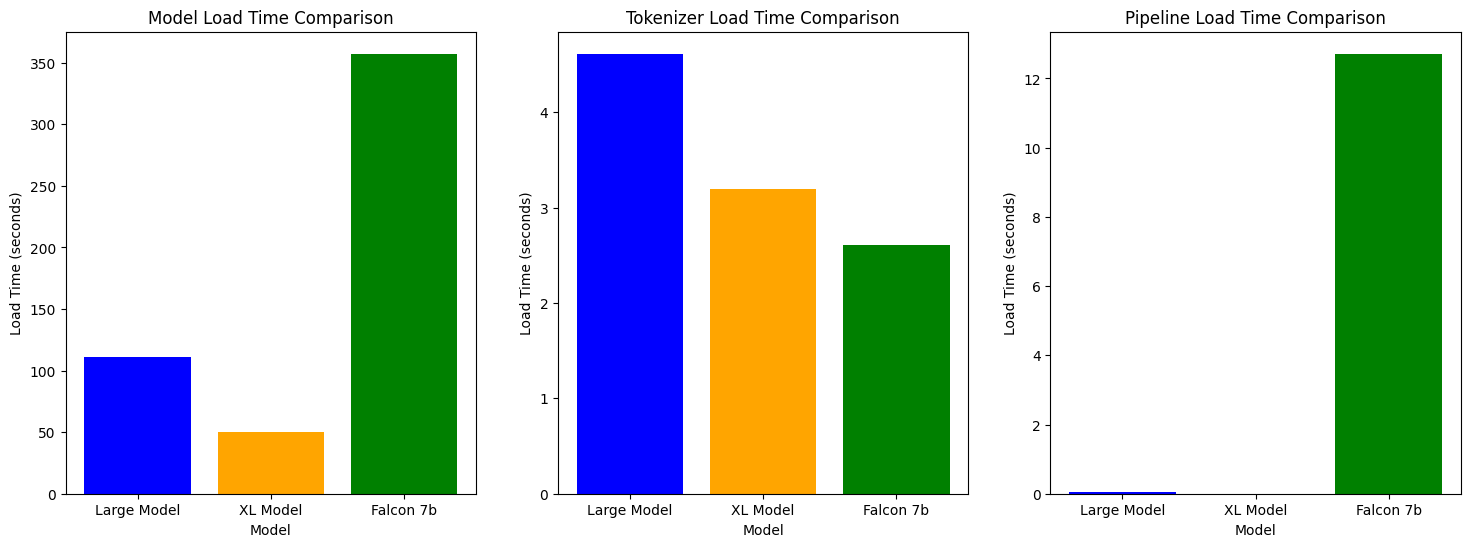

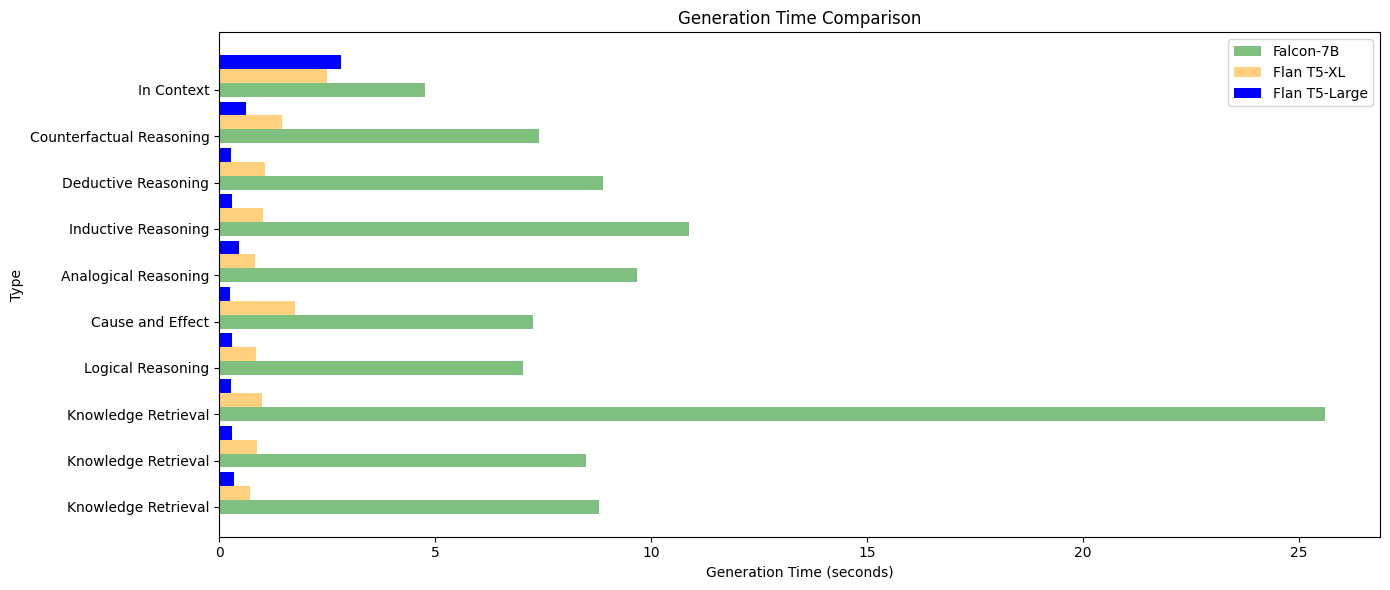

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot model load times
model_load_times = [sum(xl_model_load_times), sum(large_model_load_times), sum(falcon_model_load_times)]
model_labels = ['Large Model', 'XL Model', "Falcon 7b"]

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.bar(model_labels, model_load_times, color=['blue', 'orange', 'green'])
plt.ylabel('Load Time (seconds)')
plt.xlabel('Model')
plt.title('Model Load Time Comparison')

# Plot tokenizer load times
tokenizer_load_times = [sum(large_tokenizer_load_times), sum(xl_tokenizer_load_times), sum(falcon_tokenizer_load_times)]

plt.subplot(132)
plt.bar(model_labels, tokenizer_load_times, color=['blue', 'orange', 'green'])
plt.ylabel('Load Time (seconds)')
plt.xlabel('Model')
plt.title('Tokenizer Load Time Comparison')

# Plot pipeline load times
pipeline_load_times = [sum(large_pipeline_load_times), sum(xl_pipeline_load_times), sum(falcon_pipeline_load_times)]
plt.subplot(133)
plt.bar(model_labels, pipeline_load_times, color=['blue', 'orange', 'green'])
plt.ylabel('Load Time (seconds)')
plt.xlabel('Model')
plt.title('Pipeline Load Time Comparison')

plt.figure(figsize=(14, 6))

if len(falcon_generation_times) > 0:
    plt.barh(range(len(types)), falcon_generation_times, height=0.3, align='center', color='green', alpha=0.5, label='Falcon-7B')

if len(xl_generation_times) > 0:
    plt.barh([x + 0.3 for x in range(len(types))], xl_generation_times, height=0.3, align='center', color='orange', alpha=0.5, label='Flan T5-XL')

if len(large_generation_times) > 0:
    plt.barh([x + 0.6 for x in range(len(types))], large_generation_times, height=0.3, align='center', color='blue', label='Flan T5-Large')

plt.yticks(range(len(types)), types)
plt.ylabel('Type')
plt.xlabel('Generation Time (seconds)')
plt.title('Generation Time Comparison')
plt.legend()
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()